In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold, train_test_split
from PIL import Image
import matplotlib.pyplot as plt


# 空のDataFrameを作成
df_mae = pd.DataFrame(columns=['spectral', 'value'])
df_corespond = pd.DataFrame(columns=['spectral', 'value'])

for i in range(900, 1000, 5):

    # データへのパスを指定
    folder_path = 'C:/Users/Atsuya_Watanabe/research/2408PeachDetect/20240724AKATSUKI/HyperspectoralCameraData/processed_images_' + str(i) + 'nm'
    # folder_path = 'C:/Users/Atsuya_Watanabe/research/2408PeachDetect/20240724AKATSUKI/HyperspectoralCameraData/processed_images_reflection' + str(i) + 'nm'
    csv_path = 'C:/Users/Atsuya_Watanabe/research/2408PeachDetect/20240724AKATSUKI/SugerContentData/20240726SugercontentDestructive.csv'

    # 画像を読み込む関数
    def load_images_and_labels_from_folder(folder, csv_path, target_size=(128, 128)):
        df = pd.read_csv(csv_path)
        images = []
        labels = []
        for index, row in df.iterrows():
            filename = row['filename']
            label = row['label']
            img_path = os.path.join(folder, filename)
            if os.path.exists(img_path):
                img = Image.open(img_path).convert('RGB').resize(target_size)  # ここで画像をリサイズ
                if img is not None:
                    images.append(np.array(img))
                    labels.append(label)
        return np.array(images), np.array(labels)

    X, y = load_images_and_labels_from_folder(folder_path, csv_path)

    # データを訓練データとテストデータに分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 画像の正規化
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    # K分割交差検証
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold = 1
    val_scores = []

    print(f"Current wavelength: {i} nm")

    for train_index, val_index in kf.split(X_train):
        print(f'Fold {fold}')
        fold += 1

        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # モデルを構築
        model = keras.Sequential([
            keras.layers.Input(shape=(128, 128, 3)),
            keras.layers.Conv2D(32, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Conv2D(64, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Conv2D(128, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Flatten(),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(1)  # 回帰のための出力は1ユニット
        ])
        # 最適化手法と損失関数を指定してコンパイル
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

        # モデルの訓練
        history = model.fit(X_train_fold, y_train_fold, epochs=20, validation_data=(X_val_fold, y_val_fold), batch_size=32)

        # モデルの評価
        val_loss, val_mae = model.evaluate(X_val_fold, y_val_fold)
        val_scores.append(val_mae)
        print(f'Validation MAE for fold {fold-1}: {val_mae}')

        # 交差検証の平均スコアを計算
    average_val_score = np.mean(val_scores)
    print(f'\nAverage Validation MAE: {average_val_score}')

    # テストデータで最終評価
    test_loss, test_mae = model.evaluate(X_test, y_test)
    print(f'\nTest MAE: {test_mae}')

    df_mae = pd.concat([df_mae, pd.DataFrame({'spectral': [i], 'value': [test_mae]})], ignore_index=True)

    # テストデータに対する予測値を取得
    y_pred = model.predict(X_test)

    # 実際の値と予測値の相関係数を計算
    correlation_matrix = np.corrcoef(y_test, y_pred[:, 0])
    correlation_coefficient = correlation_matrix[0, 1]
    print('Correlation coefficient:', correlation_coefficient)

    df_corespond = pd.concat([df_corespond, pd.DataFrame({'spectral': [i], 'value': [correlation_coefficient]})], ignore_index=True)




current wave : {i}
Fold 1
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step - loss: 147.5310 - mae: 11.9933 - val_loss: 149.4836 - val_mae: 11.9759
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 145.6981 - mae: 11.9168 - val_loss: 142.6814 - val_mae: 11.6890
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 138.9551 - mae: 11.6308 - val_loss: 128.1403 - val_mae: 11.0507
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 124.5367 - mae: 10.9942 - val_loss: 102.7937 - val_mae: 9.8395
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 99.4049 - mae: 9.7860 - val_loss: 66.4861 - val_mae: 7.7834
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 63.4240 - mae: 7.7346 - val_loss: 25.6101 - val_mae: 4.4517
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 22.9903 - mae: 4.4105 - val_loss: 6.1639 - val_mae: 2.1875
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 4.0298 - mae: 1.7523 - val_loss: 46.8994 - val_mae: 6.4380
Epoch 9/20
1/1 ━━

C:\Users\Atsuya_Watanabe\AppData\Local\Temp\ipykernel_8684\553771320.py:93: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_mae = pd.concat([df_mae, pd.DataFrame({'spectral': [i], 'value': [test_mae]})], ignore_index=True)
C:\Users\Atsuya_Watanabe\AppData\Local\Temp\ipykernel_8684\553771320.py:103: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_corespond = pd.concat([df_corespond, pd.DataFrame({'spectral': [i], 'value': [correlation_coefficient]})], ignore_index=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step - loss: 147.4221 - mae: 11.9888 - val_loss: 146.2676 - val_mae: 11.8412
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 142.5107 - mae: 11.7825 - val_loss: 133.1568 - val_mae: 11.2751
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 129.5143 - mae: 11.2181 - val_loss: 107.2413 - val_mae: 10.0629
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 103.8192 - mae: 10.0089 - val_loss: 66.8385 - val_mae: 7.8066
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 63.7802 - mae: 7.7579 - val_loss: 21.2101 - val_mae: 3.9304
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 18.6574 - mae: 3.8905 - val_loss: 11.2501 - val_mae: 2.6983
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 9.2313 - mae: 2.5630 - val_loss: 52.4584 - val_mae: 6.8590
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 50.6070 - mae: 6.8755 - val_loss: 31.6607 - val_mae: 5.1178
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - lo

In [12]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold, train_test_split
from PIL import Image
import matplotlib.pyplot as plt


# 空のDataFrameを作成
df_mae = pd.DataFrame(columns=['spectral', 'value'])
df_corespond = pd.DataFrame(columns=['spectral', 'value'])

for i in range(650, 1200, 5):

    # データへのパスを指定
    folder_path = 'C:/Users/Atsuya_Watanabe/research/2408PeachDetect/20240724AKATSUKI/HyperspectoralCameraData/processed_images_' + str(i) + 'nm'
    csv_path = 'C:/Users/Atsuya_Watanabe/research/2408PeachDetect/20240724AKATSUKI/SugerContentData/20240726SugercontentDestructive.csv'

    # 画像を読み込む関数
    def load_images_and_labels_from_folder(folder, csv_path, target_size=(128, 128)):
        df = pd.read_csv(csv_path)
        images = []
        labels = []
        for index, row in df.iterrows():
            filename = row['filename']
            label = row['label']
            img_path = os.path.join(folder, filename)
            if os.path.exists(img_path):
                img = Image.open(img_path).convert('RGB').resize(target_size)  # ここで画像をリサイズ
                if img is not None:
                    images.append(np.array(img))
                    labels.append(label)
        return np.array(images), np.array(labels)

    X, y = load_images_and_labels_from_folder(folder_path, csv_path)

    # データを訓練データとテストデータに分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 画像の正規化
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    # K分割交差検証
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold = 1
    val_scores = []

    print(f"Current wavelength: {i} nm")

    for train_index, val_index in kf.split(X_train):
        print(f'Fold {fold}')
        fold += 1

        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # モデルを構築
        model = keras.Sequential([
            keras.layers.Input(shape=(128, 128, 3)),
            keras.layers.Conv2D(32, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Conv2D(64, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Conv2D(128, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Flatten(),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(1)  # 回帰のための出力は1ユニット
        ])
        # 最適化手法と損失関数を指定してコンパイル
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

        # モデルの訓練
        history = model.fit(X_train_fold, y_train_fold, epochs=20, validation_data=(X_val_fold, y_val_fold), batch_size=32)

        # モデルの評価
        val_loss, val_mae = model.evaluate(X_val_fold, y_val_fold)
        val_scores.append(val_mae)
        print(f'Validation MAE for fold {fold-1}: {val_mae}')

    # 交差検証の平均スコアを計算
    average_val_score = np.mean(val_scores)
    print(f'\nAverage Validation MAE: {average_val_score}')

    # テストデータで最終評価
    test_loss, test_mae = model.evaluate(X_test, y_test)
    print(f'\nTest MAE: {test_mae}')

    df_mae = pd.concat([df_mae, pd.DataFrame({'spectral': [i], 'value': [test_mae]})], ignore_index=True)

    # テストデータに対する予測値を取得
    y_pred = model.predict(X_test)

    # 実際の値と予測値の相関係数を計算
    correlation_matrix = np.corrcoef(y_test, y_pred[:, 0])
    correlation_coefficient = correlation_matrix[0, 1]
    print('Correlation coefficient:', correlation_coefficient)

    df_corespond = pd.concat([df_corespond, pd.DataFrame({'spectral': [i], 'value': [correlation_coefficient]})], ignore_index=True)

# 相関係数でランキングを作成
df_corespond_sorted = df_corespond.sort_values(by='value', ascending=False).reset_index(drop=True)

print("\nTop Wavelengths by Correlation Coefficient:")
print(df_corespond_sorted)


Current wavelength: 650 nm
Fold 1
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step - loss: 147.4615 - mae: 11.9903 - val_loss: 136.2184 - val_mae: 11.4130
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 132.6134 - mae: 11.3572 - val_loss: 105.9765 - val_mae: 10.0114
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 102.7767 - mae: 9.9637 - val_loss: 57.2057 - val_mae: 7.2008
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 54.6770 - mae: 7.1698 - val_loss: 9.6484 - val_mae: 2.4773
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 7.8241 - mae: 2.3145 - val_loss: 37.4726 - val_mae: 5.7898
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 35.5305 - mae: 5.7460 - val_loss: 38.2900 - val_mae: 5.8609
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 36.3362 - mae: 5.8162 - val_loss: 11.9576 - val_mae: 2.9172
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 10.2383 - mae: 2.7818 - val_loss: 4.6794 - val_mae: 1.8907
Epoch 9/20
1/1 ━

C:\Users\Atsuya_Watanabe\AppData\Local\Temp\ipykernel_8684\787932225.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_mae = pd.concat([df_mae, pd.DataFrame({'spectral': [i], 'value': [test_mae]})], ignore_index=True)
C:\Users\Atsuya_Watanabe\AppData\Local\Temp\ipykernel_8684\787932225.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_corespond = pd.concat([df_corespond, pd.DataFrame({'spectral': [i], 'value': [correlation_coefficient]})], ignore_index=True)


Current wavelength: 655 nm
Fold 1
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 146.9777 - mae: 11.9701 - val_loss: 122.0274 - val_mae: 10.7803
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 118.6836 - mae: 10.7309 - val_loss: 71.9423 - val_mae: 8.1621
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 69.3918 - mae: 8.1340 - val_loss: 14.5814 - val_mae: 3.1820
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - loss: 12.8970 - mae: 3.1873 - val_loss: 32.0152 - val_mae: 5.3470
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - loss: 29.8563 - mae: 5.2648 - val_loss: 36.6240 - val_mae: 5.7660
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 34.3760 - mae: 5.6802 - val_loss: 10.2805 - val_mae: 2.7239
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 8.5473 - mae: 2.5308 - val_loss: 4.5829 - val_mae: 1.7880
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - loss: 3.0215 - mae: 1.3575 - val_loss: 12.0789 - val_mae: 2.8696
Epoch 9/20
1/1 ━━━━━━━

  spectral     value
0      650  1.030117
1      655  1.040871
2      660  1.026393
3      665  0.954905
4      670  2.495778
  spectral     value
0      650  0.633261
1      655  0.654166
2      660  0.658889
3      665  0.648629
4      670  0.641476


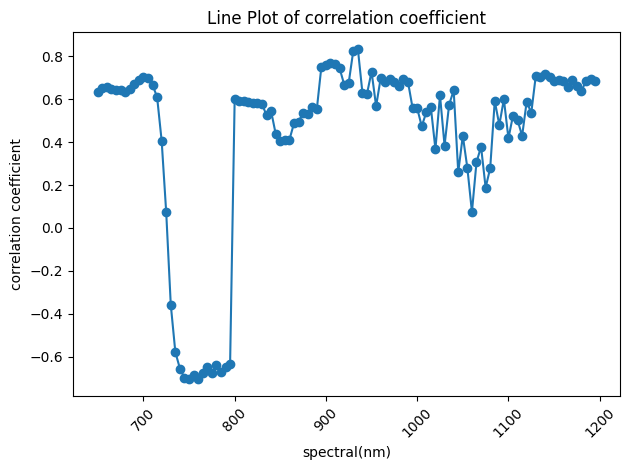

In [13]:
print(df_mae.head())
print(df_corespond.head())


# 折れ線グラフを作成
plt.plot(df_corespond['spectral'], df_corespond['value'], marker='o')

# グラフにタイトルとラベルを追加
plt.title('Line Plot of correlation coefficient')
plt.xlabel('spectral(nm)')
plt.ylabel('correlation coefficient')

# X軸のラベルを回転させる（見やすくするため）
plt.xticks(rotation=45)

# グラフを表示
plt.tight_layout()  # レイアウトの調整
plt.show()

In [ ]:
# MAEの折れ線グラフを作成
plt.figure()  # 新しい図を作成
plt.plot(df_mae['spectral'], df_mae['value'], marker='o')

# グラフにタイトルとラベルを追加
plt.title('Line Plot of MAE by Wavelength')
plt.xlabel('Spectral (nm)')
plt.ylabel('MAE')

# X軸のラベルを回転させる（見やすくするため）
plt.xticks(rotation=45)

# グラフを表示
plt.tight_layout()  # レイアウトの調整
plt.show()